## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [8]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RectWing.Models as rwm
import multiprocessing as mp

me.mechanics_printing()

In [9]:
df = pd.read_pickle('Gust_data.pkl')
df['Locked'] = pd.Categorical((df['k_fwt']>0).map({True:"Locked",False:"Free"}))
df['Gust Period'] = pd.Categorical(df['Gust Period'].round(1))
df['Gust Length'] = pd.Categorical(df.apply(lambda row: row['V']*row['Gust Period'],1).round())
df['AoA [Deg]'] = np.rad2deg(df['alpha_r'])
df.head()

,t,q,Gust Strength,Gust Period,alpha_r,C_Dmax,k_fwt,V,Lambda,Coast Angle [Deg],Attitude,Lift [N],Delta Lift [N],Fold Angle [Deg],Max lift [N],Min Lift [N],Local AoA [Deg],Locked,Gust Length,AoA [Deg]
0,0.00,"[-0.05250123585848669, 0.0, 0.0789406879895531...",8.946077,0.1,0.0,0.0,0.0,188.0,0.436332,4.522968,0,4045.052826,0.000000,4.522968,5508.587257,-1448.426644,1.909859,Free,19.0,0.0
1,0.01,"[-0.052500881304685096, 0.00012680347178590663...",8.946077,0.1,0.0,0.0,0.0,188.0,0.436332,4.522968,0,4593.191250,548.138424,4.522713,5508.587257,-1448.426644,2.169439,Free,19.0,0.0
2,0.02,"[-0.052496751161947956, 0.0008329498584887566,...",8.946077,0.1,0.0,0.0,0.0,188.0,0.436332,4.522968,0,6017.305418,1972.252592,4.519752,5508.587257,-1448.426644,2.848066,Free,19.0,0.0
3,0.03,"[-0.05248112717478686, 0.0024547932414078193, ...",8.946077,0.1,0.0,0.0,0.0,188.0,0.436332,4.522968,0,7753.293755,3708.240929,4.508600,5508.587257,-1448.426644,3.683761,Free,19.0,0.0
4,0.04,"[-0.0524446378489717, 0.004968866741827562, 0....",8.946077,0.1,0.0,0.0,0.0,188.0,0.436332,4.522968,0,9114.379768,5069.326942,4.482623,5508.587257,-1448.426644,4.352772,Free,19.0,0.0


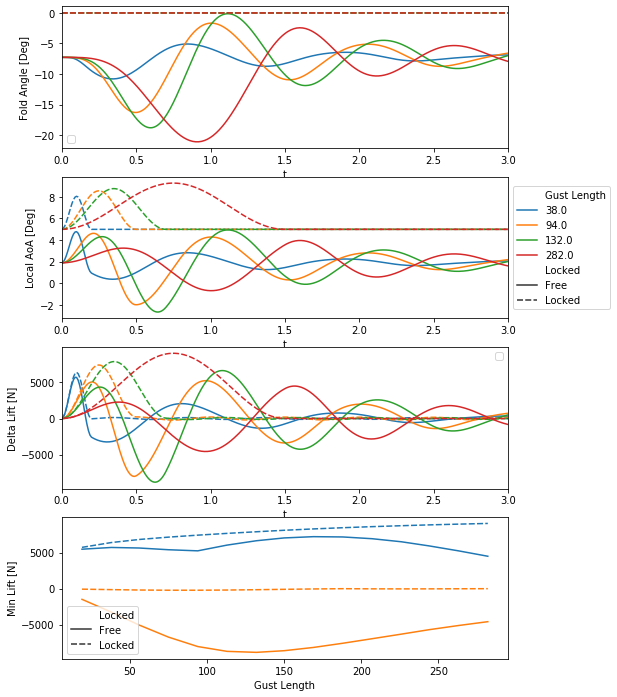

In [16]:
# compare locked and free for a given model
model = [3]
periods = [0.2,0.5,0.7,1.5]
filter_dict = {'AoA [Deg]':[5],'C_Dmax':[0],'Gust Period':periods}

data = cpo.GetReducedDataSet(df,filter_dict)

fig, axes = plt.subplots(4,1,figsize=(8,12))

sns.lineplot(data = data, x = 't',y='Fold Angle [Deg]',hue = 'Gust Length',style = 'Locked',ax = axes[0])
sns.lineplot(data = data, x = 't',y='Local AoA [Deg]',hue = 'Gust Length',style = 'Locked',ax = axes[1])
sns.lineplot(data = data, x = 't',y='Delta Lift [N]',hue = 'Gust Length',style = 'Locked',ax = axes[2])

filter_dict = {'AoA [Deg]':[5],'C_Dmax':[0],'t':[0]}
data = cpo.GetReducedDataSet(df,filter_dict)
sns.lineplot(data = data, x = 'Gust Length',y='Max lift [N]',style = 'Locked',ax = axes[3])
sns.lineplot(data = data, x = 'Gust Length',y='Min Lift [N]',style = 'Locked',ax = axes[3],legend=False)


for i in [0,1,2]:
    axes[i].set(xlim=(0,3))

axes[0].legend([])

axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
axes[2].legend([])
#axes[2].set(ylim=(-90,90))
#axes[3].set_ylabel('Max / Min WRBM')
#datav2['V'].unique()

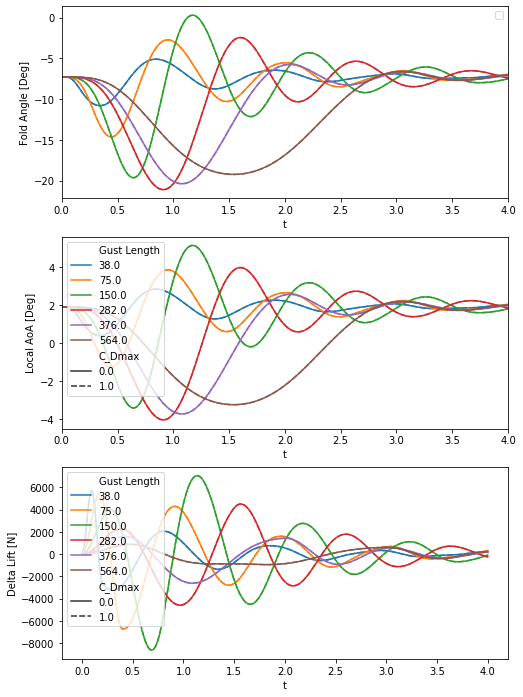

In [4]:
# compare locked and free for a given model
model = [3]
periods = [0.2,0.4,0.8,1.5,2,3]
filter_dict = {'AoA [Deg]':[5],'C_Dmax':[0,1],'Locked':['Free']}

data = cpo.GetReducedDataSet(df,filter_dict)

fig, axes = plt.subplots(3,1,figsize=(8,12))

sns.lineplot(data = data, x = 't',y='Fold Angle [Deg]',hue = 'Gust Length',style = 'C_Dmax',ax = axes[0])
sns.lineplot(data = data, x = 't',y='Local AoA [Deg]',hue = 'Gust Length',style = 'C_Dmax',ax = axes[1])
sns.lineplot(data = data, x = 't',y='Delta Lift [N]',hue = 'Gust Length',style = 'C_Dmax',ax = axes[2])

for i in [0,1]:
    axes[i].set(xlim=(0,4))

axes[0].legend([])
#axes[2].set(ylim=(-90,90))
#axes[3].set_ylabel('Max / Min WRBM')
#datav2['V'].unique()